In [15]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.data'
df = pd.read_csv(url, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings_matrix = df.pivot_table(index='user_id', columns='item_id', values='rating').fillna(0).values

X_train, X_valid = train_test_split(ratings_matrix, test_size=0.2)

In [19]:
class FISM(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super().__init__()
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))
        self.query_embeddings = nn.Embedding(num_items, embedding_dim)
        self.target_embeddings = nn.Embedding(num_items, embedding_dim)

    def forward(self, user, item_i, item_j, batch_score, n):
        user_bias = self.user_bias(user)
        item_bias = self.item_bias(item_i)

        query_emb = self.query_embeddings(item_j)
        target_emb = self.target_embeddings(item_i).unsqueeze(2)
        batch_score = batch_score.unsqueeze(1)

        sim_mat = torch.bmm(query_emb, target_emb)
        pred = torch.bmm(batch_score, sim_mat).squeeze(-1) / (n - 1)
        pred += self.global_bias + user_bias + item_bias
        return pred.squeeze(-1)

In [20]:
class FISM_simple(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super().__init__()
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))
        self.item_embeddings = nn.Embedding(num_items, embedding_dim)

    def forward(self, user, item_i, item_j, batch_score, n):
        user_bias = self.user_bias(user)
        item_bias = self.item_bias(item_i)

        query_emb = self.item_embeddings(item_j)
        target_emb = self.item_embeddings(item_i).unsqueeze(2)
        batch_score = batch_score.unsqueeze(1)

        sim_mat = torch.bmm(query_emb, target_emb)
        pred = torch.bmm(batch_score, sim_mat).squeeze(-1) / (n - 1)
        pred += self.global_bias + user_bias + item_bias
        return pred.squeeze(-1)

In [21]:
def convert_data_to_model_input(X):
    for user_idx, row in enumerate(X):
        nonzero_idx = np.nonzero(row)[0]
        nonzero = torch.tensor(row[nonzero_idx], dtype=torch.float32, device=device)
        n = len(nonzero_idx)

        if n <= 1:
            continue

        batch_i = []
        batch_j = []
        batch_score = []
        for item_idx in range(n):
            target_idx = nonzero_idx[item_idx]
            other_idxs = nonzero_idx[:item_idx].tolist() + nonzero_idx[item_idx+1:].tolist()
            batch_i.append(target_idx)
            batch_j.append(other_idxs)
            batch_score.append(row[other_idxs])

        user_idx = torch.tensor([user_idx] * n, device=device)
        batch_i = torch.tensor(batch_i, device=device)
        batch_j = torch.tensor(batch_j, device=device)
        batch_score = torch.tensor(np.array(batch_score), dtype=torch.float32, device=device)

        yield user_idx, batch_i, batch_j, batch_score, n, nonzero

In [33]:
def train(n_epoch, model, optimizer, loss_fn, device):
    model.to(device)
    train_history = []
    valid_history = []

    for epoch in range(n_epoch):
        total_train_loss = 0
        train_n = 0
        total_valid_loss = 0
        valid_n = 0

        model.train()
        for user_idx, batch_i, batch_j, batch_score, n, nonzero in convert_data_to_model_input(X_train):
            optimizer.zero_grad()
            pred = model.forward(user_idx, batch_i, batch_j, batch_score, n)
            loss = loss_fn(pred, nonzero)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * n
            train_n += n

        train_history.append(total_train_loss)
        print(f"Epoch {epoch + 1}, Train loss: {total_train_loss / train_n}, ", end="")

        model.eval()
        total_loss = 0
        with torch.no_grad():
            for user_idx, batch_i, batch_j, batch_score, n, nonzero in convert_data_to_model_input(X_valid):
                pred = model.forward(user_idx, batch_i, batch_j, batch_score, n)
                loss = loss_fn(pred, nonzero)

                total_valid_loss  += loss.item() * n
                valid_n += n

        valid_history.append(total_valid_loss)
        print(f"Valid loss: {total_valid_loss / valid_n}")

    return train_history, valid_history

In [34]:
n_users, n_items = ratings_matrix.shape
fism = FISM(n_users, n_items, 20)
optimizer = optim.Adam(fism.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

fism_loss = train(30, fism, optimizer, loss_fn, device)

Epoch 1, Train loss: 14.52595190430904, Valid loss: 12.05711110917337
Epoch 2, Train loss: 9.24380779528085, Valid loss: 8.114970367832536
Epoch 3, Train loss: 6.276654620119222, Valid loss: 5.973968330994307
Epoch 4, Train loss: 4.691684976565004, Valid loss: 4.853073682609116
Epoch 5, Train loss: 3.81831230864821, Valid loss: 4.225653746066759
Epoch 6, Train loss: 3.284619045195569, Valid loss: 3.833803665182689
Epoch 7, Train loss: 2.9191195823793317, Valid loss: 3.5612132075607823
Epoch 8, Train loss: 2.6449346759173014, Valid loss: 3.3549255715744564
Epoch 9, Train loss: 2.426524829640122, Valid loss: 3.1896867818292254
Epoch 10, Train loss: 2.24607188034468, Valid loss: 3.052463274563898
Epoch 11, Train loss: 2.0934266593860595, Valid loss: 2.935879523009565
Epoch 12, Train loss: 1.9620039012264403, Valid loss: 2.8353504942435355
Epoch 13, Train loss: 1.847148209875578, Valid loss: 2.747754651845415
Epoch 14, Train loss: 1.7454361408578007, Valid loss: 2.6708328181875314
Epoch 15

In [35]:
n_users, n_items = ratings_matrix.shape
fism_simple = FISM_simple(n_users, n_items, 20)
optimizer = optim.Adam(fism_simple.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

fism_simple_loss = train(30, fism_simple, optimizer, loss_fn, device)

Epoch 1, Train loss: 14.414634114969228, Valid loss: 12.072001800403312
Epoch 2, Train loss: 9.176883308417022, Valid loss: 8.046878921028608
Epoch 3, Train loss: 6.332024374897433, Valid loss: 5.881765433180391
Epoch 4, Train loss: 4.78714129685337, Valid loss: 4.694373126338444
Epoch 5, Train loss: 3.9093885718126518, Valid loss: 4.011819919006148
Epoch 6, Train loss: 3.374662901791144, Valid loss: 3.5890105542284263
Epoch 7, Train loss: 3.0190503443780607, Valid loss: 3.3029178668010015
Epoch 8, Train loss: 2.7616860247663606, Valid loss: 3.0927443771679455
Epoch 9, Train loss: 2.562464286209917, Valid loss: 2.927862862253474
Epoch 10, Train loss: 2.4006236055585064, Valid loss: 2.792094366709639
Epoch 11, Train loss: 2.2646534748272544, Valid loss: 2.6765060687721722
Epoch 12, Train loss: 2.147675166435784, Valid loss: 2.575938997283543
Epoch 13, Train loss: 2.0452956211086426, Valid loss: 2.487145660189289
Epoch 14, Train loss: 1.954540214652388, Valid loss: 2.4079239293611585
Epo

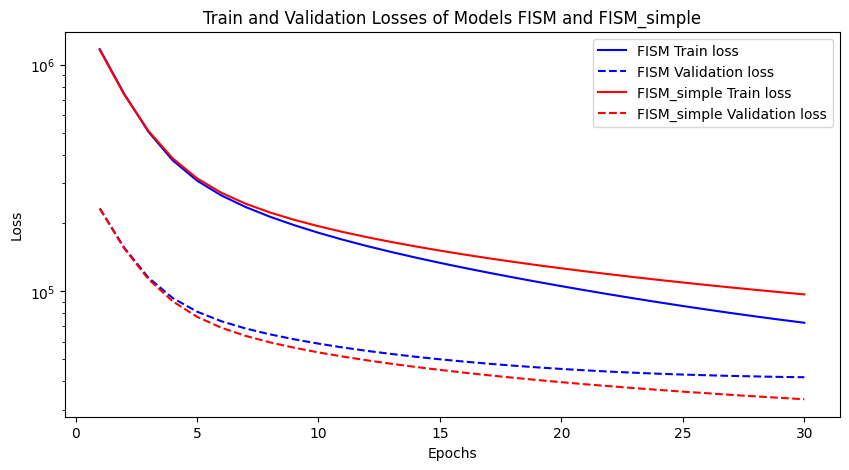

In [39]:
import matplotlib.pyplot as plt

def plot_losses(train_losses_a, valid_losses_a, train_losses_b, valid_losses_b):
    epochs = range(1, len(train_losses_a) + 1)

    plt.figure(figsize=(10, 5))

    plt.plot(epochs, train_losses_a, 'b', label='FISM Train loss')
    plt.plot(epochs, valid_losses_a, 'b--', label='FISM Validation loss')

    plt.plot(epochs, train_losses_b, 'r', label='FISM_simple Train loss')
    plt.plot(epochs, valid_losses_b, 'r--', label='FISM_simple Validation loss')

    plt.yscale('log')

    plt.title('Train and Validation Losses of Models FISM and FISM_simple')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_losses(fism_loss[0], fism_loss[1], fism_simple_loss[0], fism_simple_loss[1])